In [15]:
from sklearn.datasets import load_digits
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
from sklearn import tree
import graphviz 
from sklearn.tree import export_text

digits = load_digits()
print(digits.data.shape)


# plt.gray() 
# plt.matshow(digits.images[0]) 
# plt.show() 
print(np.max(digits.images))
print(digits.data.shape)
print(digits.data[0])
print(digits.images.shape)
print(digits.images[0])

(1797, 64)
16.0
(1797, 64)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
(1797, 8, 8)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [7]:
n_samples = len(digits.images)
data = digits.data


X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.1, shuffle=False)


In [8]:
clf = LogisticRegression(random_state=0, max_iter=5000).fit(X_train, y_train)

score = clf.score(X_train, y_train)
print("Train Score: ",score)

predict = clf.predict(X_test[:])
print(predict)

score = clf.score(X_test, y_test)
print("Test Score: ",score)

Train Score:  1.0
[5 2 8 0 1 7 6 3 2 1 7 9 6 3 1 3 9 1 7 6 8 4 3 1 4 0 5 3 6 9 6 1 7 5 4 4 7
 2 2 5 7 8 5 9 4 9 0 8 9 8 0 1 2 3 4 5 6 7 8 9 0 1 2 8 4 5 6 7 8 9 0 1 2 8
 4 5 6 7 8 9 0 9 5 5 6 5 0 9 8 9 8 4 1 7 7 3 5 1 0 0 2 2 7 8 2 0 4 2 6 8 8
 7 5 8 4 6 6 6 4 9 1 5 0 9 5 2 8 2 0 0 1 7 6 3 2 1 7 4 6 3 1 3 9 1 7 6 8 4
 5 1 4 0 5 3 6 9 6 1 7 5 4 4 7 2 8 2 2 5 7 9 5 4 8 8 4 9 0 8 9 8]
Test Score:  0.9388888888888889


Depth:  13
N Leaves:  162
Decision Tree Train Score:  1.0
Decision Tree Score:  0.7722222222222223


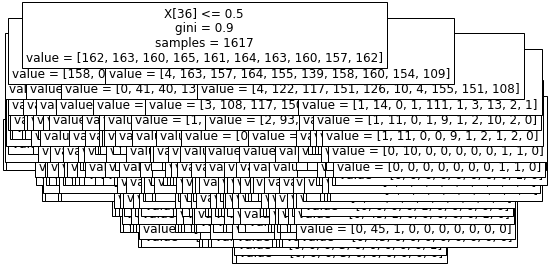

In [40]:
tree_clf = tree.DecisionTreeClassifier(max_features=50)
tree_clf = tree_clf.fit(X_train, y_train)

print("Depth: ", tree_clf.get_depth())
print("N Leaves: ", tree_clf.get_n_leaves())

tree_score = tree_clf.score(X_train, y_train)
print("Decision Tree Train Score: ",tree_score)

tree_clf.predict(X_test)
tree_score = tree_clf.score(X_test, y_test)
print("Decision Tree Score: ",tree_score)
tree.plot_tree(tree_clf, fontsize=12)
plt.show()

In [18]:
r = export_text(tree_clf)
print(r)

|--- feature_36 <= 0.50
|   |--- feature_28 <= 2.50
|   |   |--- feature_21 <= 0.50
|   |   |   |--- feature_61 <= 0.50
|   |   |   |   |--- class: 5
|   |   |   |--- feature_61 >  0.50
|   |   |   |   |--- feature_41 <= 5.50
|   |   |   |   |   |--- feature_10 <= 8.50
|   |   |   |   |   |   |--- class: 6
|   |   |   |   |   |--- feature_10 >  8.50
|   |   |   |   |   |   |--- feature_17 <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_17 >  0.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_41 >  5.50
|   |   |   |   |   |--- class: 4
|   |   |--- feature_21 >  0.50
|   |   |   |--- feature_26 <= 2.00
|   |   |   |   |--- class: 2
|   |   |   |--- feature_26 >  2.00
|   |   |   |   |--- feature_44 <= 12.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_44 >  12.50
|   |   |   |   |   |--- class: 4
|   |--- feature_28 >  2.50
|   |   |--- feature_21 <= 6.50
|   |   |   |--- feature_4 <= 8.00
|   |   |   |  

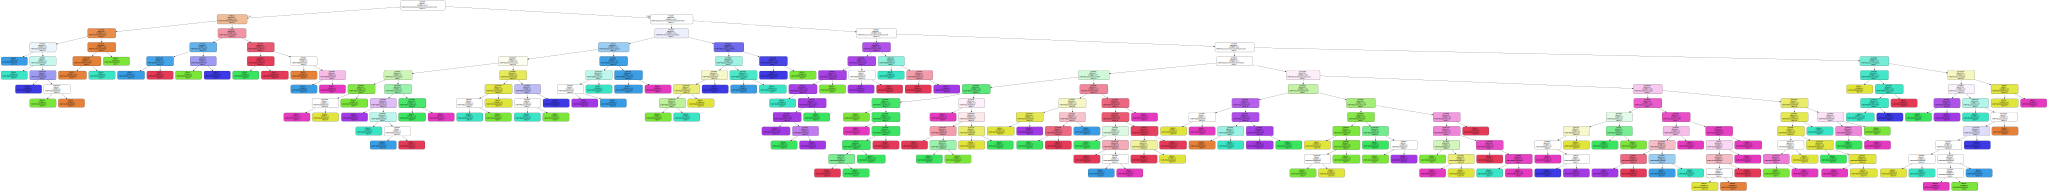

In [12]:
dot_data = tree.export_graphviz(tree_clf, out_file=None, 
                     class_names=str(digits.target_names),  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [ ]:
def plot_confusionMatrix(cld, X_test, y_test):
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test)
    disp.figure_.suptitle("Confusion Matrix")
    print(f"Confusion matrix:\n{disp.confusion_matrix}")

    plt.show()

In [ ]:
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    print(np.min(X), np.max(X))
    print(X)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})


def plot_tsne(X_train):
    X_embedded = TSNE(n_components=2).fit_transform(X_train)
    print(X_embedded)
    print(X_embedded.shape)
    plot_embedding(X_embedded, digits.target, "TSNE dos digitos")
    plt.show()